Para que el notebook funcione correctamente si va a ser ejecutado, debe usarse el comando "pip install -r requirements.txt"

# Manipulacion y representación de señales en Python

A continuación se presenta la version equivalente del código propuesto en Python, utilizando la librería numpy para la parte matemática y matplotlib para la parte gráfica

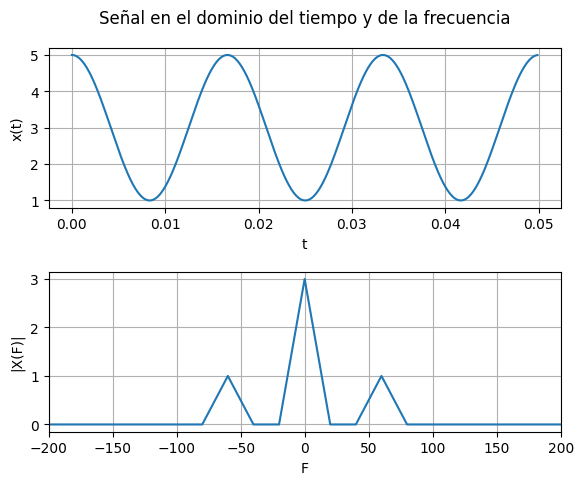

In [2]:

import numpy as np
import matplotlib.pyplot as plt


FS: int = 8000
t = np.arange(0, 0.05, 1/FS)

x = 3 + 2*np.cos(120*np.pi*t)
X = abs(np.fft.fftshift(np.fft.fft(x)))/len(x)
F = ((np.arange(0, len(x)))/len(x)-0.5)*FS


fig, (ax1, ax2) = plt.subplots(2, 1)
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)


fig.suptitle("Señal en el dominio del tiempo y de la frecuencia")

ax1.plot(t, x)
ax1.set_ylabel("x(t)")
ax1.set_xlabel("t")
ax1.grid()

ax2.plot(F, X)
ax2.set_ylabel("|X(F)|")
ax2.set_xlabel("F")
ax2.set_xlim([-200,200])
ax2.grid()


Podemos observar que en la grafica del espectro de frecuencia se muestran 2 picos a 60 y a -60 Hz, lo cual corresponde con la frecuencia de la onda seno planteada, y su valor pico corresponde a la mitad de la amplitud de la onda seno planteada. Adicionalmente se observa un pico en 0 Hz, que corresponde al nivel DC de la señal. A pesar de que se trabaja la transformada de Fourier en un dominio discreto, el resultado puede asociarse con el esperado de la transformada de Fourier continua del seno, $$F\{sin(2Ft\pi)\} = \frac{(\delta(f-F)-\delta(f+F))}{2i} $$
que corresponde a 2 impulsos en -F y F con la mitad de la amplitud, con un desfase de 90 grados, sin embargo, usualmente para graficar se toma la magnitud y por esto ambos picos son positivos y reales.

A continuación se presenta un modulo que permite grabar sonido utilizando el microfono del equipo y representandolo en el dominio del tiempo y de la frecuencia. Para el ejemplo se graba un acorde Do mayor en piano.

## Nota: Correr el siguiente modulo solo si se desea grabar de nuevo

In [66]:
import sounddevice as sd

fs = 44100  # Sample rate
seconds = 3  # Duration of recording

recording = sd.rec(int(seconds * fs), samplerate=fs, channels=1)
sd.wait()  # Wait until recording is finished


Graficamos la señal en el tiempo y en el dominio de la frecuencia.

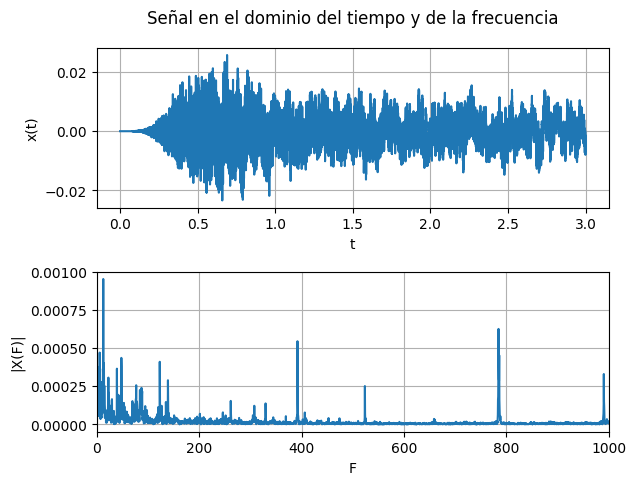

In [70]:
t = np.arange(0, seconds, 1 / fs)
X = abs(np.fft.fftshift(np.fft.fft(recording[:,0]))) / len(recording)
F = ((np.arange(0, len(recording))) / len(recording) - 0.5) * fs

fig, (ax1, ax2) = plt.subplots(2, 1)
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
fig.suptitle("Señal en el dominio del tiempo y de la frecuencia")
ax1.plot(t, recording)
ax1.set_ylabel("x(t)")
ax1.set_xlabel("t")
ax1.grid()

ax2.plot(F, X)
ax2.set_ylabel("|X(F)|")
ax2.set_xlabel("F")
ax2.set_xlim([0,1000])
ax2.grid()

En el dominio de la frecuencia podemos observar unos picos cerca a 260 Hz, 330 Hz, 390 Hz, 520 Hz, 780 Hz, los cuales son cercanos a las frecuencias de las notas Do, Mi, Sol en diferentes octavas.
En el siguiente modulo se puede reproducir el sonido, con una ampliacion con un factor de 10 debido a poca ganancia en el microfono.

In [89]:
recording_amplified = recording * 10
sd.playrec(recording_amplified, fs, 1)
sd.wait()

El siguiente bloque invierte la señal y la reproduce. Como puede escucharse, invertir la señal o en general cambiar la fase no presenta diferencias audibles en la señal, sin embargo esto no es cierto en otros aspectos, por ejemplo en el control, en los cuales la fase es determinante para la respuesta del sistema.
Si graficamos la magnitud, tampoco podriamos observar el cambio en la fase de la señal.

Text(0, 0.5, '|X(F)|')

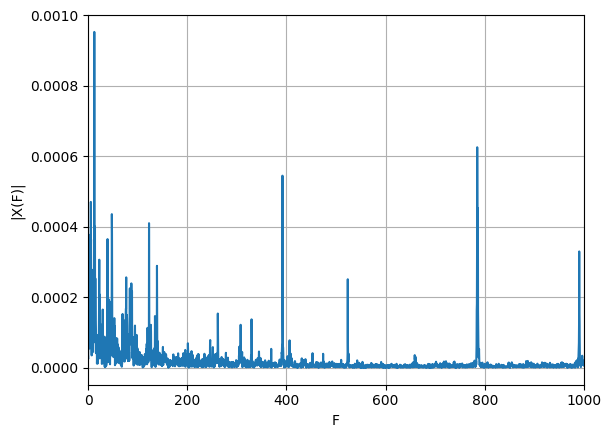

In [90]:
inverted = - recording
sd.playrec(inverted, fs, 2)
sd.wait()
X = abs(np.fft.fftshift(np.fft.fft(inverted[:,0]))) / len(inverted)
F = ((np.arange(0, len(inverted))) / len(inverted) - 0.5) * fs
plt.plot(F, X)
plt.xlim([0,1000])
plt.grid()
plt.xlabel("F")
plt.ylabel("|X(F)|")

Por otro lado, si multiplicamos la señal por un factor de 1000 y la reproducimos, se escuchará saturada y se distorsionará dependiendo de las caracteristicas del equipo donde se reproduce. En su representacion grafica cambia la amplitud y el valor de los picos

(0.0, 1000.0)

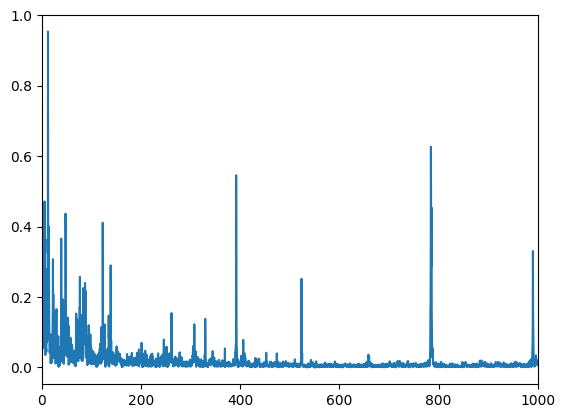

In [75]:
saturated = 1000 * recording
sd.playrec(saturated, fs, 2)
sd.wait()
X = abs(np.fft.fftshift(np.fft.fft(saturated[:,0]))) / len(saturated)
F = ((np.arange(0, len(saturated))) / len(saturated) - 0.5) * fs
plt.plot(F, X)
plt.xlim([0,1000])
plt.grid()
plt.xlabel("F")
plt.ylabel("|X(F)|")

Por otro lado, si sumamos una señal seno de una frecuencia correspondiente a La (440 Hz) podemos ver que su representacion en el dominio de la frecuencia es la original adicionandole un componente en 440 Hz  y convirtiendo el acorde en un C6

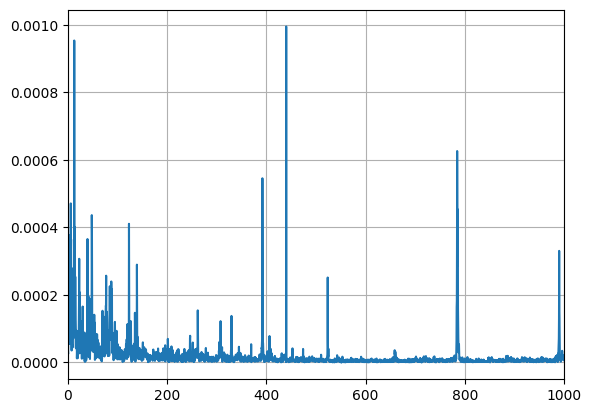

In [88]:

sinusoidal = 0.002 * np.sin(2 * np.pi * 440 * t)

result = recording[:,0] + sinusoidal
sd.playrec(5* result, fs, 2)
sd.wait()
X = abs(np.fft.fftshift(np.fft.fft(result))) / len(result)
F = ((np.arange(0, len(result))) / len(result) - 0.5) * fs
plt.plot(F, X) 
plt.xlim([0,1000])
plt.grid()
plt.xlabel("F")
plt.ylabel("|X(F)|")



# Conversion D/A: Reconstruccion de señales a partir de sus muestras

Para el siguiente ejercicio consideramos una señal cuadrada con una frecuencia de 60 Hz que fue muestreada a 1080 Hz, FS/F = 18

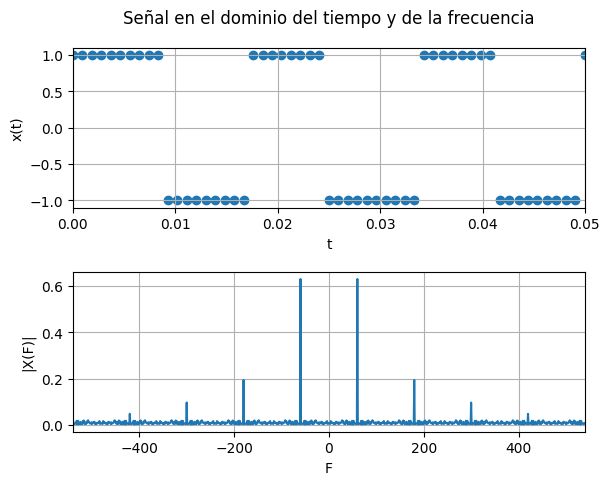

In [3]:
from scipy import signal


FS = 1080
t = np.arange(0, 1, 1 / FS)
F_signal = 60

x = signal.square(2 * np.pi * F_signal * t)

X = abs(np.fft.fftshift(np.fft.fft(x))) / len(x)
F = ((np.arange(0, len(x))) / len(x) - 0.5) * FS

fig, (ax1, ax2) = plt.subplots(2, 1)
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
fig.suptitle("Señal en el dominio del tiempo y de la frecuencia")
ax1.scatter(t, x)

ax1.set_ylabel("x(t)")
ax1.set_xlabel("t")
ax1.set_xlim([0, 0.05])
ax1.grid()
ax2.plot(F, X)
ax2.set_ylabel("|X(F)|")
ax2.set_xlabel("F")
ax2.set_xlim([-FS/2, FS/2])
ax2.grid()

En la grafica podemos ver las muestras en el dominio del tiempo y su correspondiente espectro, que tiene un componente principal a 60 Hz y armonicos que decaen en magnitud a medida que aumenta la frecuencia.

Ahora veamos la función generadora que utilizaremos para reconstruir la señal.

$$ sinc(x) = \frac{sin(\pi x)}{\pi x} $$

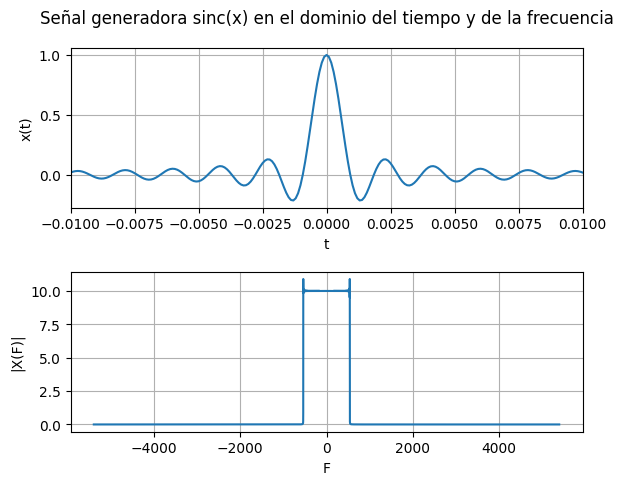

In [4]:
t_gen = np.arange(-1, 1, 1 / (10*FS))

generator_signal = np.sinc(FS * t_gen) 

X = abs(np.fft.fftshift(np.fft.fft(generator_signal)))
F = np.fft.fftshift(np.fft.fftfreq(len(generator_signal), 1 / (10*FS)))

fig, (ax1, ax2) = plt.subplots(2, 1)
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
fig.suptitle("Señal generadora sinc(x) en el dominio del tiempo y de la frecuencia")
ax1.plot(t_gen, generator_signal)
ax1.set_xlim([-0.01, 0.01])
ax1.set_ylabel("x(t)")
ax1.set_xlabel("t")
ax1.grid()
ax2.plot(F, X)
ax2.set_ylabel("|X(F)|")
ax2.set_xlabel("F")
ax2.set_xlim([-1.1* 10*FS / 2, 1.1 * 10*FS / 2])
ax2.grid()

En este caso tenemos que si la funcion generadora tiene una frecuencia $F_s = 1080 Hz$, el ancho del rectangulo es igual a dicha frecuencia. Puede observarse que al no tener la funcion para todo $t$, se crean oscilaciones cercanas a las discontinuidades.

A continuacion procedemos a realizar la reconstrucción de la señal, utilizando la expresion 
$$ x_a(t) = \sum_{n=-\infty}^{\infty}x(n).g(t-\frac{n}{F_s}) $$ 
donde
$$ g(t) = \frac{sin(\pi .F_s. t )}{\pi .F_s.t} $$ 

Para simular "continuidad" usamos un vector de tiempo con una frecuencia 10 veces la de muestreo de la señal y que abarca desde -1 s hasta 1 s, para abarcar la totalidad de la señal original de manera simétrica respecto al 0 para la señal generadora. En otros casos podria usarse un criterio como contar el número de lóbulos de la señal generadora y truncarla hasta 10 lóbulos, o ubicar cuando la función tiene un valor pico inferior al 1%.

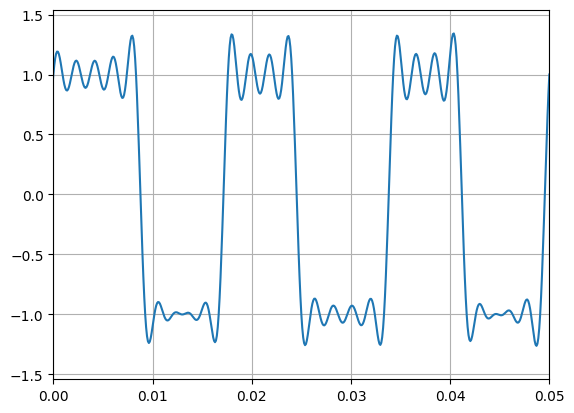

In [5]:

t_rec = np.arange(-1, 1, 1 / (10 * FS))
x_reconstructed = np.zeros_like(t_rec)

for index, _x in enumerate(x):
    time_diff = t_rec - index / FS
    x_reconstructed += _x * np.sinc(FS * time_diff) 

    
plt.plot(t_rec, x_reconstructed)
plt.xlim([0, 0.05])
plt.grid()
plt.show()

Observamos que el resultado de la reconstrucción es similar al original, sin embargo se presentan oscilaciones cercanas a los puntos donde habria discontinuidad en la funcion cuadrada ideal. Esto se conoce como el fenómeno de Gibbs, el cual se presenta al intentar reconstruir discontinuidades mediante una suma finita de términos continuos y podemos encontrarlas en otras situaciones como al intentar construir una señal con series de Fourier.

Además, realicemos la reconstrucción con un método como el de Sample & hold que es más utilizado en los conversores, con una frecuencia 10 veces la de muestreo original para efectos de visualización.

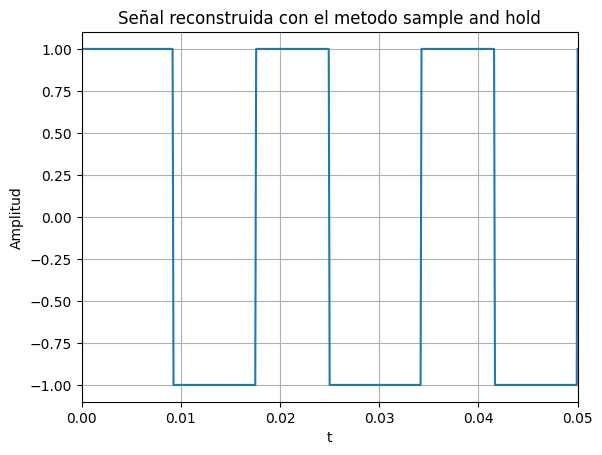

In [103]:
FS = 1080
def sample_and_hold(signal, fs, t):

    ts = 1 / fs  
    signal_reconstructed = np.zeros_like(t) 
    sample_indices = np.floor(t / ts).astype(int)
    sample_indices = np.clip(sample_indices, 0, len(signal) - 1)
    signal_reconstructed = signal[sample_indices]

    return signal_reconstructed


t_rec = np.arange(-1, 1, 1 / (10 * FS))
x_reconstructed = sample_and_hold(x, FS, t_rec)


plt.plot(t_rec, x_reconstructed)
plt.xlim([0, 0.05])
plt.xlabel('t')
plt.ylabel('Amplitud')
plt.title('Señal reconstruida con el metodo sample and hold')
plt.xlim([0, 0.05])
plt.grid(True)
plt.show()

Vemos que en este caso la señal reconstruida es perfectamente cuadrada, superando a la reconstrucción con la función $sinc(x)$., sin sus oscilaciones cercanas a las discontinuidades, sin embargo, esto no siempre será así para todas las señales. En general utilizando la función $sinc(x)$ se podría obtener la señal reconstruida a la perfección si se cumplen los criterios de Nyquist, acompañandola de otros procedimientos como enventanados.

A pesar de esto, la técnica más utilizada es la de sample and hold, pues es más liviana computacionalmente, además, la reconstrucción con la función $sinc(x)$ no es causal, requiere muestras futuras y por ello no puede ser implementada en tiempo real, sin contar con que su implementación en sistemas offline es considerablemente mas compleja que el sample and hold.

# Procesamiento de pantalla verde

Para el siguiente ejercicio se propone el cambio de fondo de una imagen, la cual inicialmente tiene en el fondo una pantalla verde.
Cargamos la imagen y la mostramos en el espacio RGB (openCV trabaja con BGR)


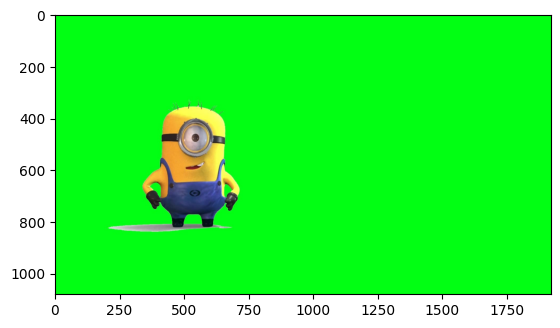

In [105]:
import matplotlib.pyplot as plt
import cv2

img = cv2.imread("./green_screen.jpg")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

Luego graficamos el histograma, donde vemos que hay 3 picos considerables que corresponden al conteo de pixeles que conforman el fondo verde

[]

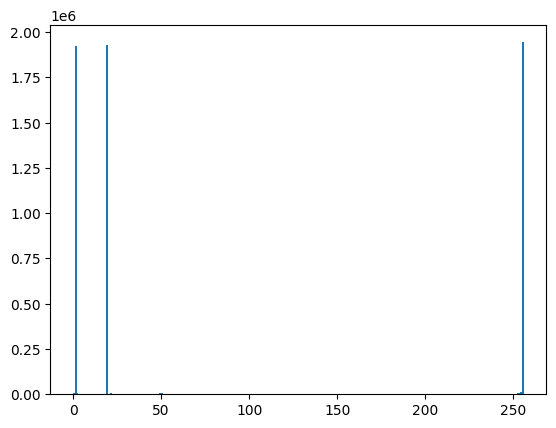

In [4]:
plt.hist(img.ravel(), 256, [0, 256])   
plt.plot()

Ampliamos el histograma para ver el resto de valores

(0.0, 5000.0)

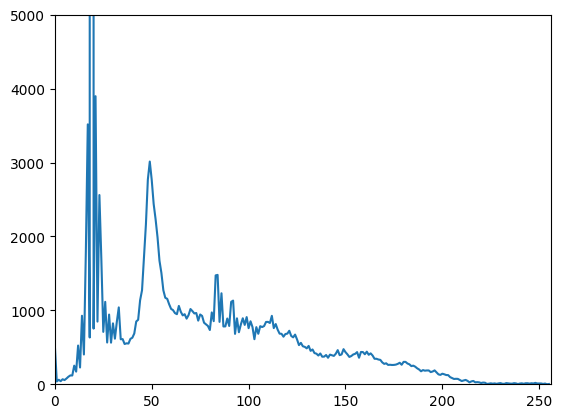

In [26]:

# fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
# ax1.hist(b.ravel(), 256, [0, 256])
hist = cv2.calcHist([img], [0], None, [256], [0, 256])

fig, ax = plt.subplots()
ax.plot(hist)
ax.set_xlim([0, 256])
ax.set_ylim([0, 5000])
# ax2.hist(g.ravel(), 256, [0, 256])
# ax3.hist(r.ravel(), 256, [0, 256])
# plt.show()

Ahora vamos a eliminar el color de aquellos pixeles donde el valor de verde exceda un umbral de 200 y que los demás canales sean inferiores a 50, para evitar eliminar pixeles blancos. El valor de 200 ofrece cierta tolerancia para incluir pixeles verdes que pueden ser modificados por la cercania a objetos.

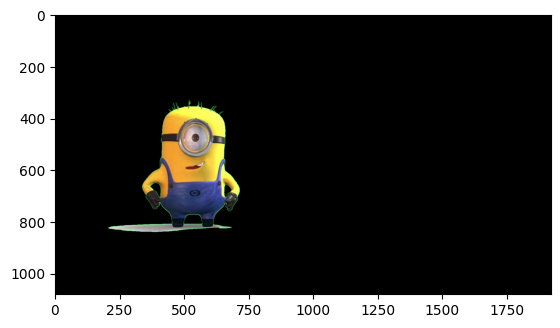

In [107]:
b, g, r = cv2.split(img)
img[:, :][(g > 200) & (r < 50)] = [0,0,0]

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

Ahora carguemos para el fondo una imagen familiar.

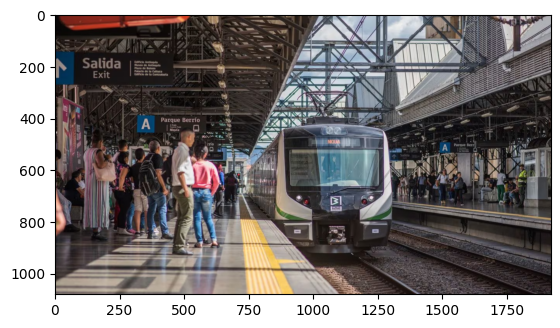

In [106]:
background = cv2.imread("./background.jpg")
background = cv2.resize(background, (img.shape[1], img.shape[0]))
plt.subplots()
plt.imshow(cv2.cvtColor(background, cv2.COLOR_BGR2RGB))

Y sumemos la imagen previa sin el fondo. pero no podemos hacerlo directamente, pues podriamos exceder los valores de 255.
Para esto usaremos varias mascaras, para excluir del fondo la zona donde la imagen original tiene contenido. Esto lo logramos estableciendo un umbral para los pixeles en blanco y negro. Invertimos la máscara y aplicamos una operacion and con el fondo. y sumamos los resultados
Abajo podemos ver paso a paso cada resultado.

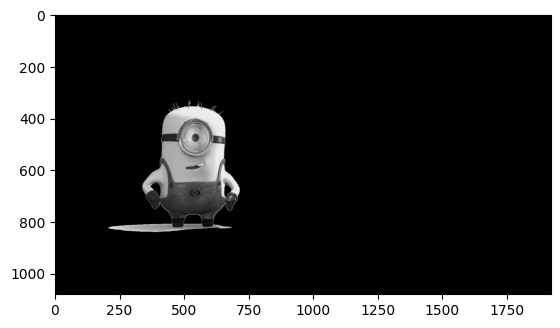

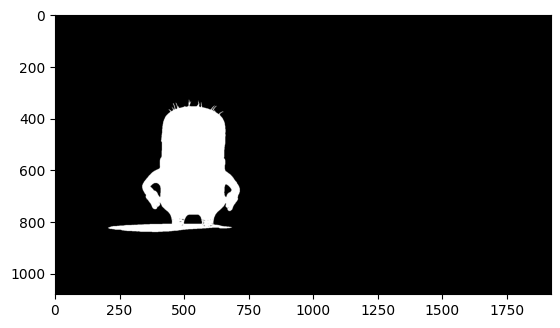

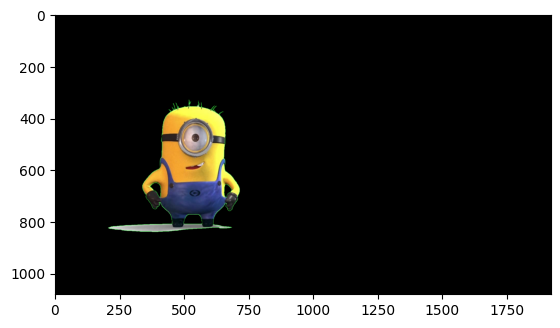

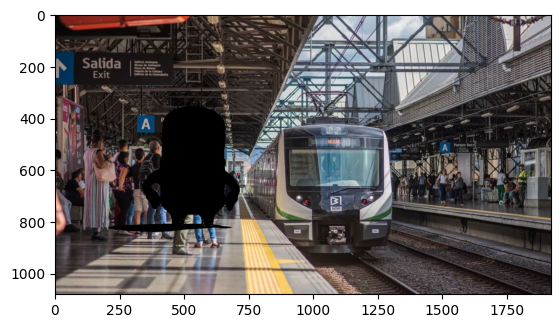

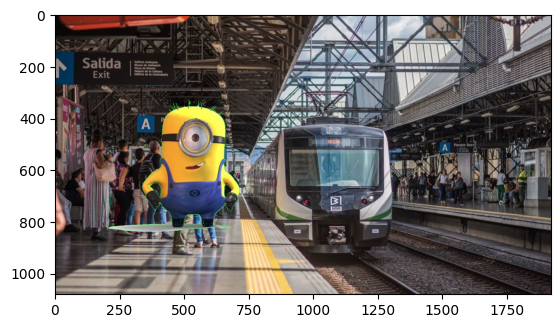

In [109]:
rows, cols, channels = background.shape

plt.subplots()
img2gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(cv2.cvtColor(img2gray, cv2.COLOR_BGR2RGB))

plt.subplots()
ret, mask = cv2.threshold(img2gray, 10, 255, cv2.THRESH_BINARY)
plt.imshow(mask, cmap="gray")
mask_inv = cv2.bitwise_not(mask)
plt.subplots()
img1_fg = cv2.bitwise_and(img, img, mask=mask)
plt.imshow(cv2.cvtColor(img1_fg, cv2.COLOR_BGR2RGB))


img2_bg = cv2.bitwise_and(background, background, mask=mask_inv)
plt.subplots()
plt.imshow(cv2.cvtColor(img2_bg, cv2.COLOR_BGR2RGB))
dst = cv2.add(img1_fg, img2_bg)
plt.subplots()
plt.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))


Podemos ver que el minion ahora está cómodo esperando el metro de Medellín.

Ahora podemos aplicarlo iterativamente a un video. En el siguiente bloque saldrá una pantalla emergente con un video de una explosión. (Si no puede verla probablemente la ventana está detras de este editor o está en otra pantalla.)

In [8]:
import cv2
cap = cv2.VideoCapture("video_green_screen.mp4")
ret, frame = cap.read()
while 1:
    ret, frame = cap.read()
    
    try:
        cv2.imshow("frame", frame)
    except: 
        pass
    if cv2.waitKey(1) & 0xFF == ord("q") or ret == False:
        cap.release()
        cv2.destroyAllWindows()
        break

Podemos iterar sobre sus fotogramas y aplicar el mismo procedimiento que en la imagen anterior

In [9]:
cap = cv2.VideoCapture("video_green_screen.mp4")
ret, frame = cap.read()
while 1:
    ret, frame = cap.read()

    try:
        b, g, r = cv2.split(frame)
        frame[:, :][(g > 100) & (b < 50)] = [0,0,0]
        cv2.imshow("frame", frame)
    except:
        pass
    if cv2.waitKey(1) & 0xFF == ord("q") or ret == False:
        cap.release()
        cv2.destroyAllWindows()
        break

Y de manera similar podemos cambiar el fondo, causando una explosion en el Metro.

In [10]:
cap = cv2.VideoCapture("video_green_screen.mp4")
ret, frame = cap.read()
background = cv2.imread("./background.jpg")
while 1:
    ret, frame = cap.read()

    try:
        b, g, r = cv2.split(frame)
        frame[:, :][(g > 100) & (b < 50)] = [0,0,0]
        img2gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        ret, mask = cv2.threshold(img2gray, 10, 255, cv2.THRESH_BINARY)
        mask_inv = cv2.bitwise_not(mask)
        img1_fg = cv2.bitwise_and(frame, frame, mask=mask)
        img2_bg = cv2.bitwise_and(background, background, mask=mask_inv)
        dst = cv2.add(img1_fg, img2_bg)
        cv2.imshow("frame", dst)

    except:
        pass
    if cv2.waitKey(1) & 0xFF == ord("q") or ret == False:
        cap.release()
        cv2.destroyAllWindows()
        break

# Simulación de la Localizacion Binaural

Para este ejercicio se realizará una simulacion de localización binaural, para simular una fuente de sonido en una ubicacion arbitraria. Se inicia permitiendo la grabación de un sonido con el microfono del equipo.

In [28]:
import numpy as np
import sounddevice as sd
import soundfile as sf

(audio_sample, fs) = sf.read("audio.wav", dtype="float32")

audio_sample = audio_sample[:len(audio_sample)//2]
sd.play(audio_sample, fs)
sd.wait()

<sounddevice.CallbackFlags: output underflow>

Luego se consideran varios valores como la velocidad del sonido, un ángulo azimutal para ubicar la fuente (-90 grados es a la izquierda y 90 es a la derecha), una distancia y un radio de la cabeza.
Luego se calculan valores de desfase temporal segun el ángulo y el radio de la cabeza y la velocidad del sonido. y por ultimo un factor de atenuación. 
Para desfasar la señal en cada uno de los canales se utiliza la funcion roll que desplaza n numero de posiciones la señal, el desfase es positivo para el canal izquierdo y negativo para el derecho. Luego con ambos canales se hace la mezcla estereo y se reproduce.

In [36]:
azimuth = -90   
distance = 5  
speed_of_sound = 343 
head_radius = 0.09  
itd = head_radius * np.sin(np.radians(azimuth)) / speed_of_sound
ild = 20 * np.log10(1 / distance)
left_channel = np.roll(audio_sample, int(itd * 44100))
right_channel = np.roll(audio_sample, -int(itd * 44100))
right_channel *= 10 ** (ild / 20)
left_channel *= 10 ** (ild / 20)
stereo_signal = np.column_stack((left_channel, right_channel))

sd.playrec(stereo_signal, samplerate=44100, channels=2)
sd.wait()

<sounddevice.CallbackFlags: input overflow, output underflow>

Como se escucha en el audio, se logra una simulación satisfactoria, que se notará mucho mejor si se utilizan audifonos. La diferencia en distancia entre un oido y otro suele ser despreciable a comparación de la distancia de la fuente, por esto el factor que más define la ubicación es el desfase y no la amplitud de la señal.

# Series de Fourier

Para este ejercicio, se plantea la reconstrucción de una señal utilizando series de Fourier. Para este caso se selccionó una señal triangular simétrica e impar, cuyos coeficientes estan dados por 
$$ \frac{4i(-1)^{n}}{\pi^{2}k^2}$$

Se considera solo la parte imaginaria pues es una funcion impar.
A continuación se muestra la señal y varios casos de reconstrucción hasta los primeros 10 armónicos.

C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


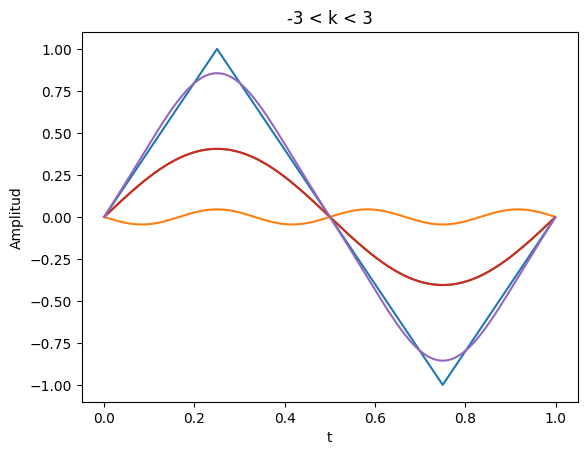

In [11]:
import scipy as sp
import numpy as np 
import matplotlib.pyplot as plt

t = np.arange(0, 1, 1/1000)

triangle_signal = sp.signal.sawtooth((2 * np.pi) * t + np.pi / 2, 0.5)
plt.plot(t, triangle_signal)


harmonics = []
coefficients = []
for k in range(-3,3):
    if k != 0 and k % 2 != 0:
        coefficients.append( 1j*(-1)**k *4 / (np.pi**2 * k**2) * np.sin(k* np.pi/2))
        harmonics.append( 1j*(-1)**k *4 / (np.pi**2 * k**2) * np.sin(k* np.pi/2)*(np.exp(1j * 2 * np.pi * k * t)))
for harmonic in harmonics:
    plt.plot(t, harmonic)   
plt.plot(t, sum(harmonics))
plt.title("-3 < k < 3")
plt.xlabel("t")
plt.ylabel("Amplitud")
plt.show()

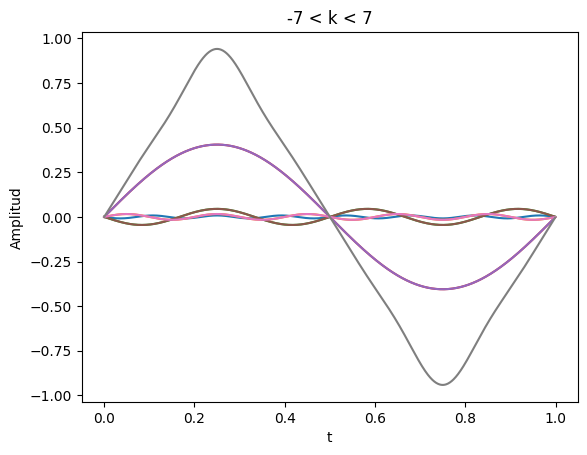

In [12]:
harmonics = []
coefficients = []

for k in range(-7, 7):
    if k != 0 and k % 2 != 0:
        coefficients.append(
            1j * (-1) ** k * 4 / (np.pi**2 * k**2) * np.sin(k * np.pi / 2)
        )
        harmonics.append(
            1j
            * (-1) ** k
            * 4
            / (np.pi**2 * k**2)
            * np.sin(k * np.pi / 2)
            * (np.exp(1j * 2 * np.pi * k * t))
        )
for harmonic in harmonics:
    plt.plot(t, harmonic)
plt.plot(t, sum(harmonics))
plt.title("-7 < k < 7")
plt.xlabel("t")
plt.ylabel("Amplitud")
plt.show()

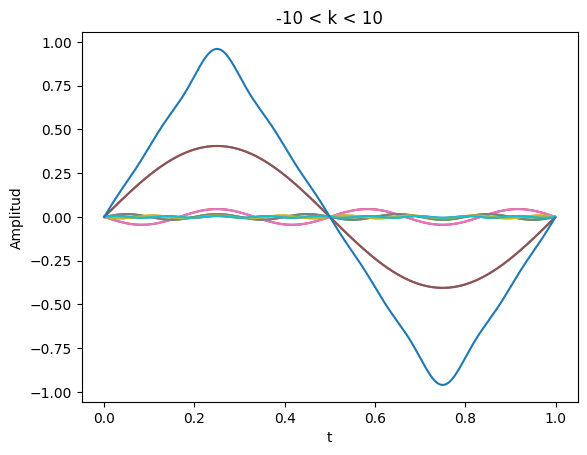

In [13]:
harmonics = []
coefficients = []

for k in range(-10, 10):
    if k != 0 and k % 2 != 0:
        coefficients.append(
            1j * (-1) ** k * 4 / (np.pi**2 * k**2) * np.sin(k * np.pi / 2)
        )
        harmonics.append(
            1j
            * (-1) ** k
            * 4
            / (np.pi**2 * k**2)
            * np.sin(k * np.pi / 2)
            * (np.exp(1j * 2 * np.pi * k * t))
        )
for harmonic in harmonics:
    plt.plot(t, harmonic)
plt.plot(t, sum(harmonics))
plt.title("-10 < k < 10")
plt.xlabel("t")
plt.ylabel("Amplitud")
plt.show()

Vemos que a medida que se aumenta el numero de armónicos, la función triangular reconstruida a partir de sus componentes se parece cada vez mas a la original.
Además de calcular usando la fórmula teorica de la serie de Fourier, podemos encontrar la magnitud y la fase de los componentes usando la transformada de Fourier, donde los componentes distintos de cero son los coeficientes de la serie. a continuacion se calcula la transformada de Fourier de la señal triangular y se toman sus coeficientes mas representativos.

Podemos observar que al multiplicar el coeficiente (no en magnitud unicamente, sino el numero complejo completo) por $e^{-i k t \pi}$ obtenemos cada uno de los componentes que se deben sumar para obtener la función original. 
Abajo imprimimos la lista de coeficientes calculados con la fórmula de la serie de Fourier y los obtenidos por la transformada de Fourier y vemos que coinciden perfectamente. 

Coeficientes calculados
[-0.-0.40528473j  0.+0.04503164j -0.-0.01621139j  0.+0.00827112j
 -0.-0.00500352j  0.+0.00500352j -0.-0.00827112j  0.+0.01621139j
 -0.-0.04503164j  0.+0.40528473j]
Coeficientes obtenidos por FFT
[-0.-0.40528607j  0.+0.04503297j -0.-0.01621272j  0.+0.00827245j
 -0.-0.00500485j  0.+0.00335079j -0.-0.00239947j  0.+0.0018026j
 -0.-0.0014037j   0.+0.00112401j -0.-0.00112401j  0.+0.0014037j
 -0.-0.0018026j   0.+0.00239947j -0.-0.00335079j  0.+0.00500485j
 -0.-0.00827245j  0.+0.01621272j -0.-0.04503297j  0.+0.40528607j]


C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0, 0.5, 'Amplitud')

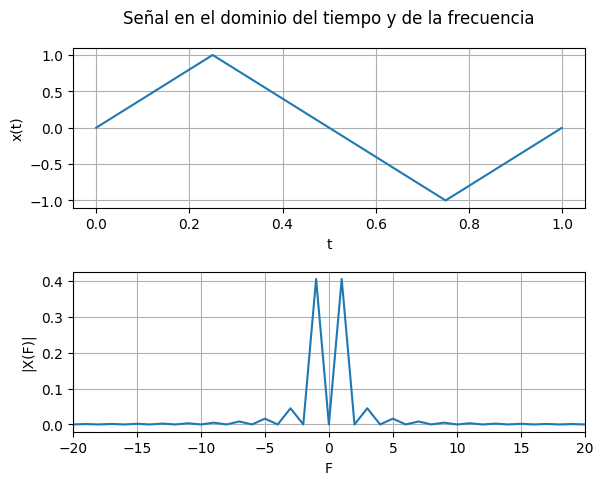

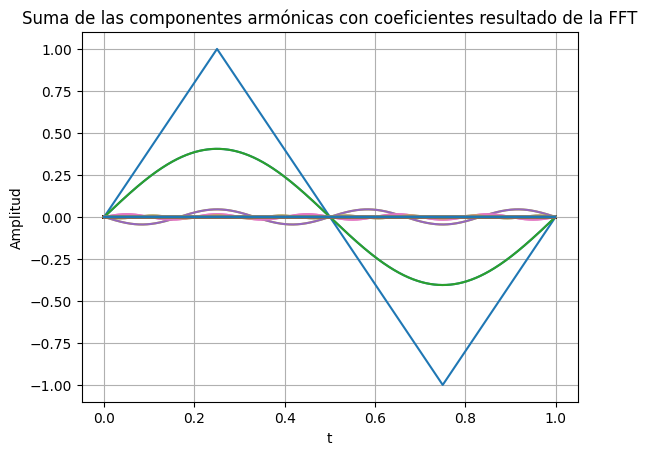

In [15]:
X = np.fft.fftshift(np.fft.fft(triangle_signal))/len(triangle_signal)
F = ((np.arange(0, len(triangle_signal)))/len(triangle_signal)-0.5)*1000
print("Coeficientes calculados")
print(1j*np.imag(np.fft.fftshift(coefficients)))
Xunshifted = np.fft.fft(triangle_signal)/len(triangle_signal)
print("Coeficientes obtenidos por FFT")
print(1j * np.imag(Xunshifted[abs(Xunshifted) > 1e-3]))

harmonics = []

Xfiltered = X[abs(X) > 1e-3]
terms = list(range(-len(Xunshifted) // 2, len(Xunshifted) // 2))

for index, k in enumerate(X):
    harmonics.append(k * (np.exp(1j * 2 * np.pi * terms[index] * t)))


fig, (ax1, ax2) = plt.subplots(2, 1)
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
fig.suptitle("Señal en el dominio del tiempo y de la frecuencia")
ax1.plot(t, triangle_signal)
ax1.set_ylabel("x(t)")
ax1.set_xlabel("t")
ax1.grid()
ax2.plot(F, abs(X))
ax2.set_ylabel("|X(F)|")
ax2.set_xlabel("F")
ax2.set_xlim([-20,20])
ax2.grid()


plt.subplots()
plt.grid()
plt.plot(t, sum(harmonics))
for harmonic in harmonics:
    plt.plot(t, harmonic)
plt.title("Suma de las componentes armónicas con coeficientes resultado de la FFT")
plt.xlabel("t")
plt.ylabel("Amplitud")